# Laboratorio de Habla 3: Construcción de un Vocoder

## Objetivos de Aprendizaje
1. Manipular y visualizar señales de voz en Julia.
2. Realizar un análisis LPC de la señal de voz en Julia.
3. Reconstruir señales usando filtros de reconstrucción.

## Consejos para la Solución
- Utiliza las convenciones de Julia para escribir código.
- Copia el texto de los enunciados como parte (comentada) de un fichero de Julia para ejecutarlo.

## Introducción: la Vocodificación LPC
...

## Ejercicio 1: Análisis Exploratorio de la Señal
### Objetivo
Determinar si la señal puede ser sujeta a codificación LPC efectiva.
### Contenido


1. Lea y reproduzca la señal de voz proporcionada.


In [1]:
using WAV
señal, fs = wavread("confront.wav")
wavplay(señal,fs)



2. Represente el sonido en el dominio del tiempo.


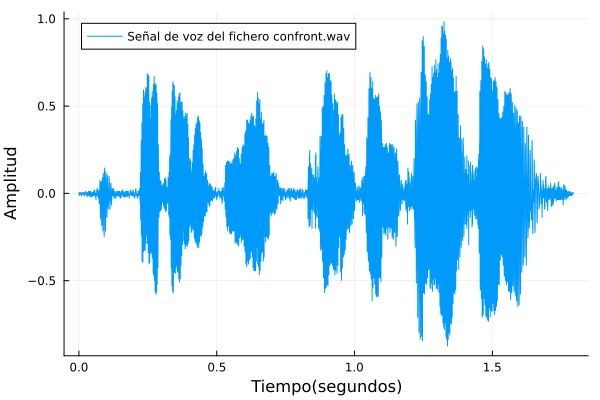

In [2]:
using Plots #tengo que representarlo en tiempo 
d = (length(señal)-1)*(1/fs)
t = 0:1/fs:d
plot(t, señal, label = "Señal de voz del fichero confront.wav" , xlabel = "Tiempo(segundos)", ylabel = "Amplitud")



3. Represente la energía localizada y la tasa de cruces por cero como función del tiempo, entramando la señal con diferentes tamaños de ventana y usando las primitivas desarrolladas en la práctica 2.


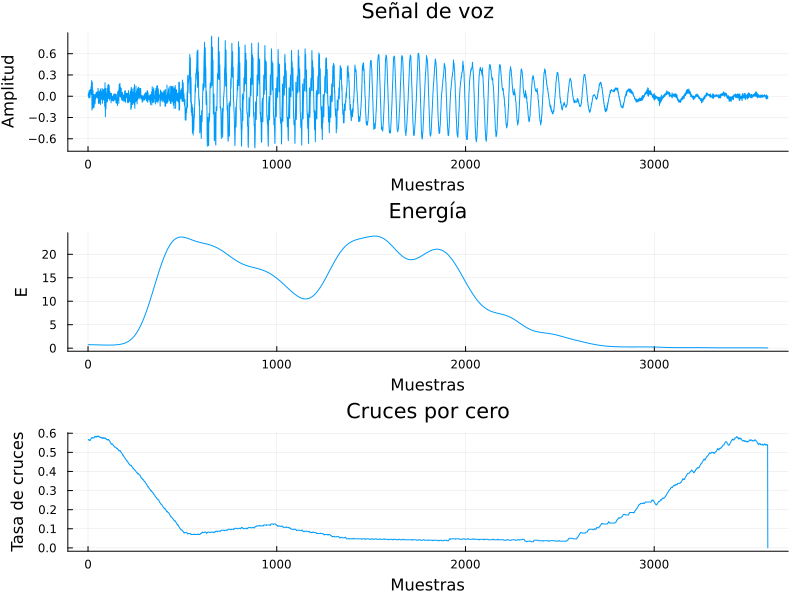

In [3]:

using DSP
using FFTW


Tamaño = 7/1000
N = round(Int, Tamaño*fs)
t = (1:N)/fs

#definimos las ventanas de hamming
ventana_1 = hamming(N) # tamaño muy pequeño 
ventana_2 = hamming(400) # tamaño mediano 
ventana_3 = hamming(2000) # tamaño muy grande 

p1 = plot(t, ventana_1, label = "ventana hamming 1", xlabel = "tamaño")
p2 = plot(ventana_2, label = "ventana hamming 2", xlabel = "tamaño")
p3 = plot(ventana_3, label = "ventana hamming 3", xlabel = "tamaño")

plot(p1,p2,p3, layaut=(3,1)) #para dibujar las ventanas hamming 
segmento = señal[15500:19500]

# Función para calcular la energía con ventana

function energia(s,h)
    Lt = length(s) - length(h)
    E = zeros(Lt)
   
    for n in 1:Lt
      E[n] = sum((s[1+n:length(h)+n] .* h).^2)
    end
    return E
end

#Para sacar la energia localizada de cada una de ellas 
energia_1 = energia(segmento, ventana_1)
energia_2 = energia(segmento, ventana_2)
energia_3 = energia(segmento, ventana_3)

plot(energia_1, title = "Energía para diferentes ventanas Hamming", label = "Ventana 1", xlabel = "Número de ventanas", ylabel = "Energia")
plot!(energia_2, label = "Ventana 2")
plot!(energia_3, label = "Ventana 3")
function zcr(s, L)
  # calcula la tasa de cruces por cero, de la señal s, en tramas de L longitud
   
    Zcr = zeros(length(s) - L + 1)
   
    for n in 2:length(s) - L
      Zcr[n] = sum(0.5 / L * abs.(sign.(s[1 + n:L + n]) - sign.(s[n:L + n - 1])))
    end
   
    Zcr[1] = Zcr[2]
   
    return Zcr
end
   
function vozSS(s, h)
    s = s .- sum(s) / length(s)
    E = energia(s, h)
    Zcr = zcr(s, length(h))
   
    plot1 = plot(s[1:length(s) - length(h)], title="Señal de voz", xlabel = "Muestras", ylabel = "Amplitud", legend=false)
    plot2 = plot(E, title="Energía", xlabel = "Muestras", ylabel = "E", legend=false)
    plot3 = plot(Zcr, title="Cruces por cero", xlabel = "Muestras", ylabel = "Tasa de cruces", legend=false)
    
    plot(plot1, plot2, plot3, layout=(3,1), size=(800,600))
end

ventana_hamming = hamming(400)
vozSS(segmento, ventana_hamming)


## Ejercicio 2: Análisis de una trama
### Objetivo
Desarrollar el código de análisis-síntesis.
### Contenido


In [4]:
# imports
# using Pkg
# Pkg.add("LPC")
using DSP
using FFTW
using WAV
using Plots
using ToeplitzMatrices
using StatsBase
using LinearAlgebra


1. Seleccione y visualice en el tiempo y la frecuencia una trama sonora de la señal.


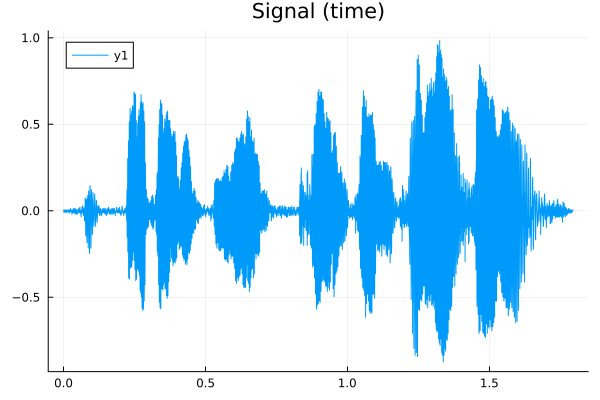

In [5]:
confront, fs = wavread("./confront.wav")

d = (length(confront)-1)*(1/fs)
t = 0:1/fs:d

p1 = plot(t, confront, title="Signal (time)")

# calculate signal frecuency
# contfront_fft = fftshift(fft(confront))
# contfront_fft_module = abs.(contfront_fft)
# frequencies = fftshift(fftfreq(length(t), fs))

# p2 = plot(abs.(frequencies), contfront_fft_module, title="Signal (Frec)", xlabel="Frecuencies (Hz)", ylabel="|FFT|")

plot(p1, layout=(1,1))

# visualizamos la señal en el tiempo para localizar una trama sonora


Visualmente, vemos una trama sonora por ejemplo desde el segundo 0.5 hasta el 0.7 aproximadamente, vamos a comprobarlo entramando la señal.

19581
19778
19778
19778


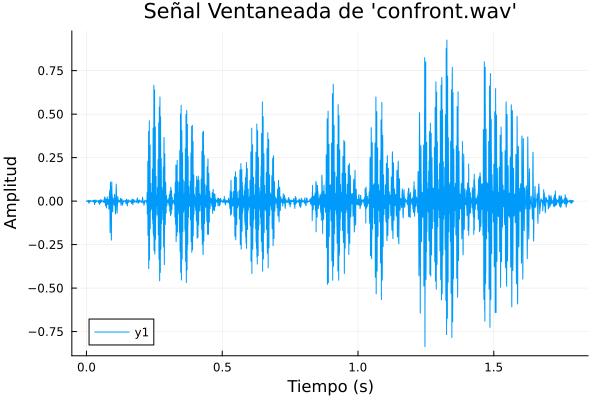

In [6]:
function aplicar_ventana(signal, fs)
  duracion_trama = 0.02  # Duración de la trama en segundos
  tamaño_trama = round(Int, duracion_trama * fs)  # Número de muestras en la trama
  ventana = hamming(tamaño_trama)

  datos_ventaneados = []

  paso_muestras = round(Int, 0.02 * fs)  # Número de muestras para avanzar cada 20 ms

  for i in 1:paso_muestras:length(signal)
      if length(signal) < i+tamaño_trama-1
        println(i)
        trama = signal[i:length(signal)]
        trama_ventaneada = trama .* ventana[1:length(trama)]
        datos_ventaneados = vcat(datos_ventaneados, trama_ventaneada)
      else
        trama = signal[i:i+tamaño_trama-1]
        trama_ventaneada = trama .* ventana
        datos_ventaneados = vcat(datos_ventaneados, trama_ventaneada)
      end
  end

  return convert(Vector{Float64}, datos_ventaneados)
end

confront, fs = wavread("./confront.wav")
d = (length(confront)-1)*(1/fs)
t = 0:1/fs:d

ventaneado = aplicar_ventana(confront, fs)

println(length(ventaneado))
println(length(confront))
println(length(t))

# Visualizar resultados
plot(t, ventaneado, xlabel="Tiempo (s)", ylabel="Amplitud",
   title="Señal Ventaneada de 'confront.wav'")

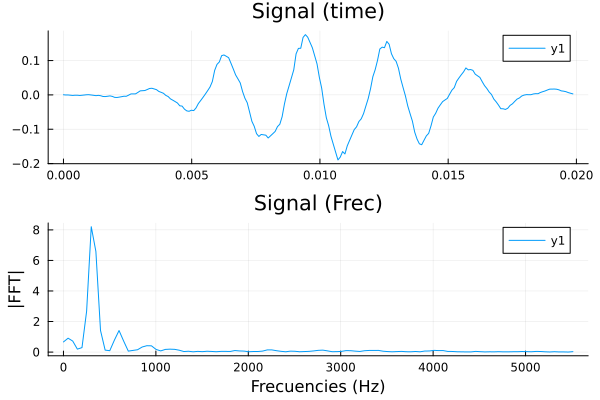

In [7]:

# function get_trama_by_window()
d_ventana = 0.02
n = fs * d_ventana
N = Int(round(n))

ventana = DSP.hamming(N)

trama_sin_ventana = confront[5800+1:5800+N]

trama = trama_sin_ventana .* ventana


d = (length(trama)-1)*(1/fs)
t = 0:1/fs:d

p1 = plot(t, trama, title="Signal (time)")

# calculate signal frecuency
trama_fft = fftshift(fft(trama))
trama_fft_module = abs.(trama_fft)
frequencies = fftshift(fftfreq(length(t), fs))

p2 = plot(abs.(frequencies), trama_fft_module, title="Signal (Frec)", xlabel="Frecuencies (Hz)", ylabel="|FFT|")

plot(p1, p2, layout=(2,1))

2. Obtenga la función de autocorrelación de la trama usando una función xcorr que reciba una trama y un orden y obtenga el vector de autocorrelación de ese orden.


221


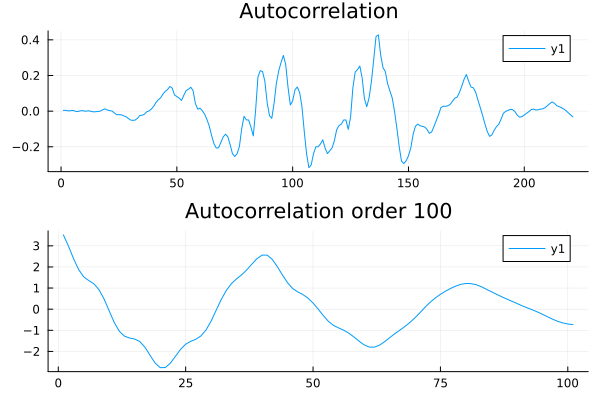

In [8]:
function autocorrelacion_orden(trama, orden)

  autocorrelacion = xcorr(trama, trama)

  orden = min(orden, length(autocorrelacion) - 1)

  autocorrelacion_orden = autocorrelacion[length(trama) + 1 : length(trama) + orden + 1]

  return autocorrelacion, autocorrelacion_orden
end

function sonido_sonoro_enventanado()
  
  N = 220
  trama_sin_ventana = confront[9600:9600+N]     # trama sonora

  trama_enventanada = aplicar_ventana(trama_sin_ventana, fs)

  return trama_enventanada
end

N = 220

trama_sin_ventana = confront[9600:9600+N]     # trama sonora

trama_enventanada = aplicar_ventana(trama_sin_ventana, fs)

order = 100
autocorrelacion, acorr_order = autocorrelacion_orden(trama_enventanada, order)

p1 = plot(trama_enventanada, title="Autocorrelation")
p2 = plot(acorr_order, title="Autocorrelation order $order")

plot(p1, p2, layout=(2,1))

3. Genere la matriz R usando la biblioteca ToeplitzMatrices.jl


In [9]:
function generar_matriz_R(trama, orden)
  # Calcula la autocorrelación de la trama hasta el orden deseado
  autocorrelacion, autocorrelacion_orden_n = autocorrelacion_orden(trama, orden)
  
  # Genera la matriz toeplitz a partir del vector de autocorrelación
  matriz_R = Toeplitz(autocorrelacion_orden_n, autocorrelacion_orden_n)
  return matriz_R
end

trama = sonido_sonoro_enventanado()
orden_autocorrelacion = 10

matriz_R = generar_matriz_R(trama, orden_autocorrelacion)

# show matrix
# show(IOContext(stdout, :limit=>false), MIME"text/plain"(), matriz_R)

221


11×11 Toeplitz{Float64, Vector{Float64}, Vector{Float64}}:
  3.51862     2.98503    2.39142   …  0.475396  -0.0849525  -0.636534
  2.98503     3.51862    2.98503      0.921013   0.475396   -0.0849525
  2.39142     2.98503    3.51862      1.19864    0.921013    0.475396
  1.87425     2.39142    2.98503      1.35334    1.19864     0.921013
  1.52941     1.87425    2.39142      1.52941    1.35334     1.19864
  1.35334     1.52941    1.87425   …  1.87425    1.52941     1.35334
  1.19864     1.35334    1.52941      2.39142    1.87425     1.52941
  0.921013    1.19864    1.35334      2.98503    2.39142     1.87425
  0.475396    0.921013   1.19864      3.51862    2.98503     2.39142
 -0.0849525   0.475396   0.921013     2.98503    3.51862     2.98503
 -0.636534   -0.0849525  0.475396  …  2.39142    2.98503     3.51862

4. Obtenga los coeficientes de predicción lineal usando el sistema anterior.


221


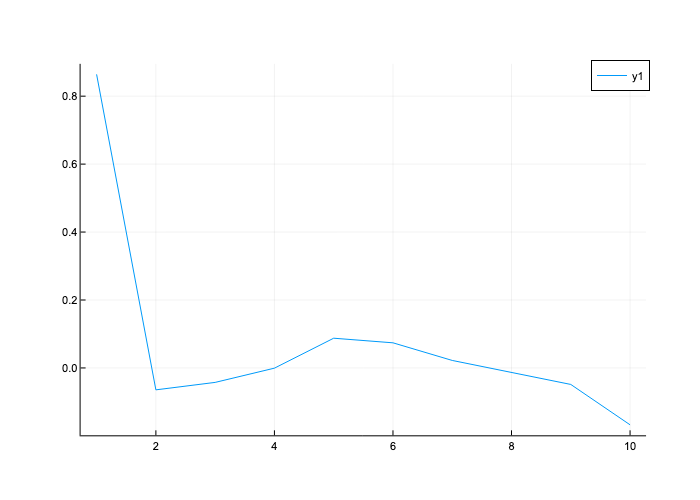

In [21]:
function calcular_coeficientes(trama, orden)

  autocorrelacion, autocorrelacion_orden_n = autocorrelacion_orden(trama, orden)
  
  # R = generar_matriz_R(trama, orden)[1:end-1, 1:end-1]
  R = generar_matriz_R(trama, orden)

  R_prima = R[1:end-1, 1:end-1] # llegamos hasta p-1

  r =  R[1,2:end] # from 1 to p

  matriz_r = reshape(r, (length(r), 1))

  # show(IOContext(stdout, :limit=>false), MIME"text/plain"(), R_prima)
  # show(IOContext(stdout, :limit=>false), MIME"text/plain"(), matriz_r)

  ak = R_prima \ matriz_r
  
  return ak[:,1]
end

trama = sonido_sonoro_enventanado()
orden_autocorrelacion = 10

ak = calcular_coeficientes(trama, orden_autocorrelacion)
plot(ak)

221
0.08782420600286714

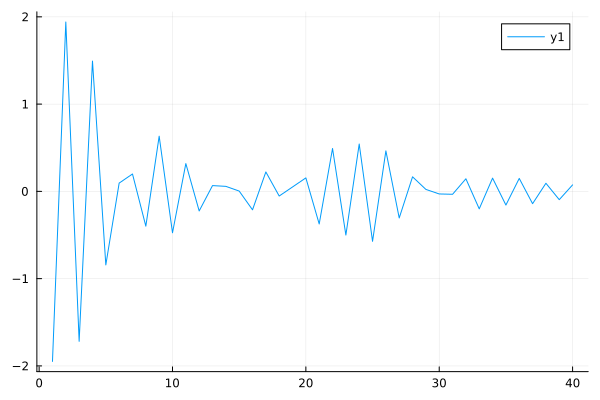

In [11]:
# coeficientes ak a partir de la funcion lpc de DSP.jl

trama = sonido_sonoro_enventanado()
orden_autocorrelacion = 40

aks, prediction_err = lpc(trama, orden_autocorrelacion, LPCLevinson())
print(prediction_err)
plot(aks)


## Ejercicio 3: Síntesis de una trama
### Objetivo
Depurar el código de análisis-síntesis.
### Contenido



1. Obtenga, para la trama dada, el error de predicción como una señal, filtrando la trama a través del filtro FIR inverso.


In [12]:
# TEST FUNCTIONS

function coeficientes_prediccion_lineal(sw, orden)
  r = crosscov(sw, sw)
  R = Toeplitz(r[1:orden],  r[1:orden])
  a = R \ r[2:orden+1]
  return a
end

function error_prediccion(sw, orden)
  # Obtén los coeficientes de predicción lineal
  a = coeficientes_prediccion_lineal(sw, orden)
  
  # Filtro FIR inverso
  b = [1.0, -a']  # Los coeficientes son [1, -a[1], -a[2], ..., -a[p]]
  
  # Filtra la trama original
  print("this is b")
  println(b)
  error = DSP.conv(b[2], sw)
  
  return error
end

sw = confront[5800:6200]
orden = 2

error = error_prediccion(sw, orden)

this is bAny[1.0, [-1.2165974473116385 -0.2823240430937145]]


401×2 Matrix{Float64}:
 -0.00477097  -0.00110715
 -0.00477097  -0.00110715
  0.00477097   0.00110715
  0.00477097   0.00110715
  0.0143129    0.00332146
  0.0238549    0.00553577
  0.0143129    0.00332146
  0.0143129    0.00332146
  0.0238549    0.00553577
  0.0143129    0.00332146
  0.00477097   0.00110715
 -0.00477097  -0.00110715
 -0.00477097  -0.00110715
  ⋮           
  0.0238549    0.00553577
 -0.0429387   -0.00996438
 -0.0811065   -0.0188216
 -0.119274    -0.0276788
 -0.176526    -0.0409647
 -0.224236    -0.0520362
 -0.214694    -0.0498219
 -0.224236    -0.0520362
 -0.243319    -0.0564648
 -0.186068    -0.043179
 -0.1479      -0.0343217
 -0.119274    -0.0276788

2. Sintetice la trama de voz analizada mediante el filtro de síntesis calculado en el apartado 1.4


221


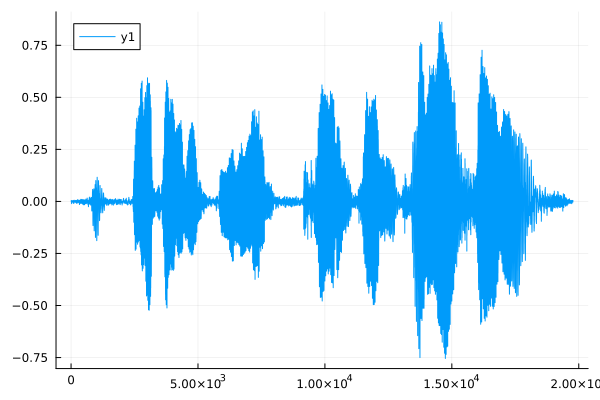

In [13]:
trama = sonido_sonoro_enventanado()
orden_autocorrelacion = 10

ak = calcular_coeficientes(trama, orden_autocorrelacion)

filtrada = filtfilt(ak, confront)

plot(filtrada)


In [23]:

wavplay(filtrada, fs)

221


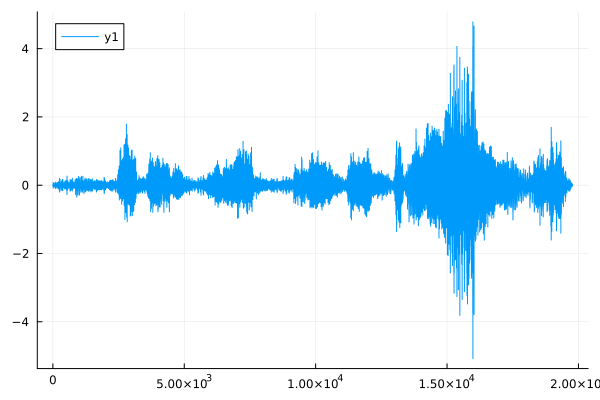

In [15]:
# Con las funciones de DSP.jl
trama = sonido_sonoro_enventanado()
orden_autocorrelacion = 40

ak, prediction_err = lpc(trama, orden_autocorrelacion, LPCLevinson())

filtrada = filtfilt(ak, confront)
plot(filtrada)

In [22]:
# sound
wavplay(filtrada, fs)

3. Inspeccione, auditivamente, en el tiempo y en la frecuencia las tramas de voz original y sintetizada. ¿Son correctos los coeficientes de análisis-síntesis?


Yo creo que si, a la hora de sintetizar con un orden bastante grande, vemos que el sonido reproducido no tiene sentido, y cada vez se escucha peor. La señal sintetizada con un orden p = 10 se aproxima bastante a lo óptimo


## Ejercicio 4: Síntesis LPC
### Objetivo
Realizar el análisis-síntesis LPC de una elocución de voz.
### Contenido



1. Identificar si cada trama de voz es sonora o sorda usando tanto la tasa de cruces por cero como la energía localizada.


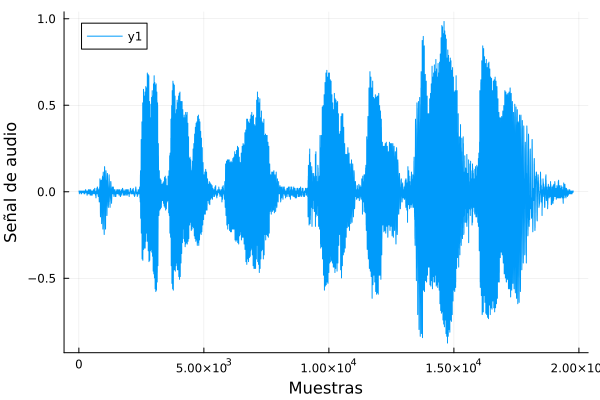

In [17]:
# mostramos la señal en muestras normales para ver de que rango (visualmente) es sorda o sonora,
# y lo comprobaremos posteriormente

signal = confront
plot(signal, xlabel="Muestras", ylabel="Señal de audio")

Serian por ejemplo, dos tramas sordas:
* [1500:2000]
* [8000:9000]

Y tramas sonoras:
* [6600:7600]
* [16000:16600]

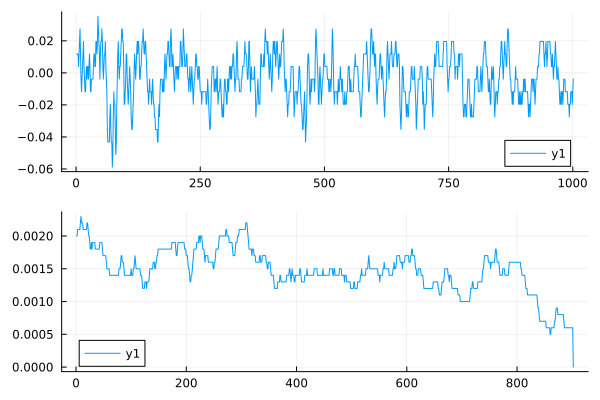

In [18]:
# Cruces por cero y energia de las tramas sordas

sorda_1 = confront[1500:2000]
sorda_2 = confront[8000:9000]

function zcr(s, window)
  # calcula la tasa de cruces por cero, de la señal s, en tramas de L longitud

  L = length(window)
  Zcr = zeros(length(s) - L + 1)

  for n in 2:length(s) - L
    Zcr[n] = sum(0.5 / L * abs.(sign.(s[1 + n:L + n]) - sign.(s[n:L + n - 1])))
  end

  Zcr[1] = Zcr[2]

  return Zcr / L
end

function cruces_energia(signal, window)

  print("test")

end

function visualizar(trama)
  N = 100 # tamaño de ventana
  h_window = DSP.hamming(N)
  Zcr = zcr(trama, h_window)

  p1 = plot(trama)
  p2 = plot(Zcr)

  plot(p1, p2, layout=(2,1))
end

visualizar(sorda_1)
visualizar(sorda_2)




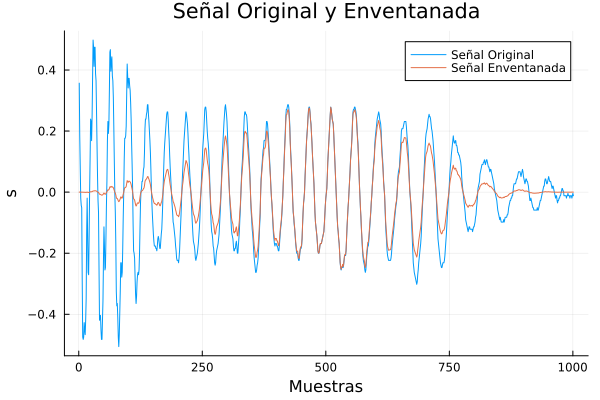

In [19]:
# Identificamos si una trama es sorda o sonora, y la tasa de cruces por 0 y energia, por partes.

# funcion para la energia

function energia(s,h)

  # h - ventana de hamming
  # s - segmento de la señal
  # E = energia(s, h)
  Lt = length(s) - length(h)
  E = zeros(Lt)

  d = (length(confront)-1)*(1/fs)
  t = 0:1/fs:d

  for n in 1:Lt
    E[n] = sum((s[1+n:length(h)+n] .* h).^2)
  end

  # Gráfico
  p1 = plot(t, s, title="Señal s", xlabel="Muestras", ylabel="s", legend=false)
  p2 = plot(E, title="Energía", xlabel="Muestras", ylabel="E", legend=false)

  plot(p1, p2, layout=(2, 1))
end

function enventanado(signal, hamming, position)
  enventanada = signal .* hamming
  plot(signal, label="Señal Original")
  plot!(enventanada, label="Señal Enventanada", title="Señal Original y Enventanada", xlabel="Muestras", ylabel="s", legend=true)
end

signal = confront
trama = confront[12000:13000]
h_window = DSP.hanning(length(trama))

enventanado(trama, h_window, position)

# energia(signal, h_window)

WebIO._IJuliaInit()

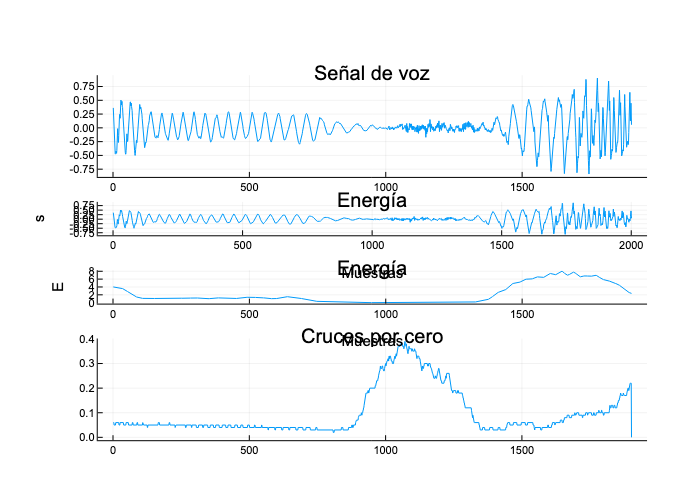

In [20]:
# tasa de cruces por cero
include("functions.jl")

signal = confront
segmento = confront[12000:14000]
h_window = DSP.hamming(100)

vozSS(segmento, h_window)




2. Calcular la frecuencia fundamental de las tramas sonoras, si puede, usando la FFT.


3. De nuevo, calcule la frecuencia fundamental pero usando en este caso la autocorrelación. ¿En qué propiedad fundamental de la teoría de señales se basa este método? Para responder, reflexione acerca de lo que es la función de autocorrelación desarrollada más arriba.


4. Encuentre una trama sorda y una trama sonora de su señal de voz como en 1.3 y calcule y visualice sus autocorrelaciones como en 2.2. Para la trama sonora, estime el tono fundamental como en 4.1


5. Halle los espectros de las tramas seleccionadas y represéntelos para explorarlos.


6. Construya una función que reciba una trama y devuelva todos los parámetros de análisis necesarios para re-sintetizar la trama.


7. Construya una función que reciba todos los parámetros de análisis y reconstruya una trama de voz en el tiempo.


8. Para toda la señal de voz s[n] diseñe e implemente un esquema de enventanado con ventanas de longitud N que se solapen un 50% de la longitud. Ayúdese de alguna referencia técnica si no entiende qué tiene que hacer. También, decida qué orden de filtro LPC va a usar...


9. Sobre el diseño de enventanado anterior, cuando pase por una trama, analícela y sintetícela para construir una señal aproximada sZ[n].


10. Compare s[n] y su aproximación sZ[n] visual y auditivamente. Investigue diferentes valores del orden del filtro. ¿Puede observar algún efecto en la señal reconstruida?

## Ejercicio 5: Reflexión
### Objetivo
Aprender a descubrir y ser consciente de los resultados de aprendizaje propios.
### Actividad
Escriba un párrafo listando los conocimientos y destrezas adquiridos en esta práctica.
